In [1]:
import networkx as nx
import matplotlib.pyplot as plt

from pprint import pprint as pp
from typing import Dict, List, Tuple

import random
import csv

In [2]:
G = nx.tutte_graph()

## Visualization

In [3]:
def generate_graph(nodes: List) -> nx.Graph:
    R = nx.Graph()
    R.add_nodes_from(nodes)
    R.add_edges_from(nx.utils.pairwise(nodes))
    return R

In [4]:
def get_node_color_result(kinputs, koutputs, union_result):
    color_map = []
    for n in union_result:
        if n in kinputs:
            color_map.append("green")
        elif n in koutputs:
            color_map.append("blue")
        else:
            color_map.append("yellow")
    return color_map

In [5]:
def get_edge_weight(G, result):
    r = result.edges()
    
    ans = []
    for g in G.edges():
        if g in r:
            ans.append(5)
        else:
            ans.append(1)
    return ans

In [6]:
def visualize_graph(Graph: nx.Graph, figsize: tuple=(15,15), color_map: List[str]=None, node_size: int=3000, with_labels: bool=True) -> None:
    if color_map == None:
        color_map = "yellow"
    else:
        color_map = color_map
    
    plt.figure(1,figsize=figsize) 
    nx.draw_kamada_kawai(Graph, node_color=color_map, with_labels=with_labels, node_size=node_size, font_size=20,font_family="Noto Serif CJK JP")
    plt.show()

In [7]:
def visualize_graph_in_all(Graph: nx.Graph, figsize: tuple=(15,15), color_map: List[str]=None, node_size: int=3000, weights: List[int] = None, with_labels: bool=True) -> None:
    if color_map == None:
        color_map = "yellow"
    else:
        color_map = color_map
    
    plt.figure(1,figsize=figsize) 
    nx.draw_kamada_kawai(Graph, node_color=color_map, with_labels=with_labels, node_size=node_size, font_size=20,width=weights,font_family="Noto Serif CJK JP")
    plt.show()

# Algorithm

In [8]:
inputs = [5,8]
# outputs = [27,2]
outputs = [23,16,12]

## Brute Force

In [9]:
def find_path_bf(MOrig: List, MDest: List) -> nx.Graph:
    
    result = []
    
    for kin in MOrig:
        for kout in MDest:
            sp_raw = nx.dijkstra_path(G, source=kin, target=kout)
            sp_graph = generate_graph(sp_raw)
            
            result.append(sp_graph)
    
    
    return nx.compose_all(result)        

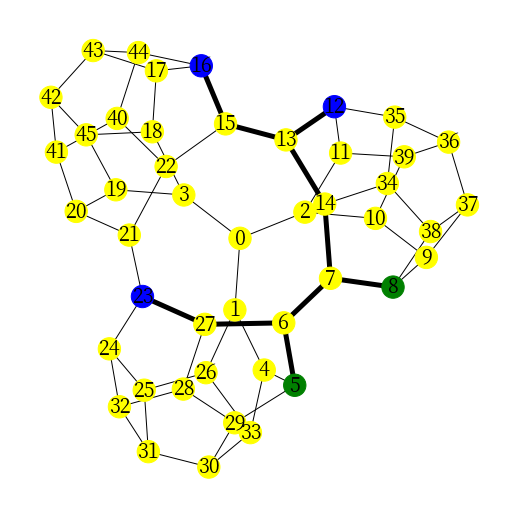

In [10]:
result = find_path_bf(inputs, outputs)
visualize_graph_in_all(Graph=G, figsize=(7,7), node_size=500, weights=get_edge_weight(G, result),color_map=get_node_color_result(inputs, outputs, G))

## A*

In [11]:
def common_neighbor(u, v):
    return len(list(nx.common_neighbors(G, u, v)))

In [12]:
def jaccard_function(u, v):
    union_size = len(set(G[u]) | set(G[v])) # union neighbor
    if union_size == 0:
        return 0
    return len(list(nx.common_neighbors(G, u, v))) / union_size

In [13]:
def find_path_astar(MOrig: List, MDest: List, heuristic_func) -> nx.Graph:
    
    result = []
    
    for kin in MOrig:
        for kout in MDest:
            sp_raw = nx.astar_path(G, source=kin, target=kout, heuristic=heuristic_func)
            sp_graph = generate_graph(sp_raw)
            
            result.append(sp_graph)
    
    
    return nx.compose_all(result)        

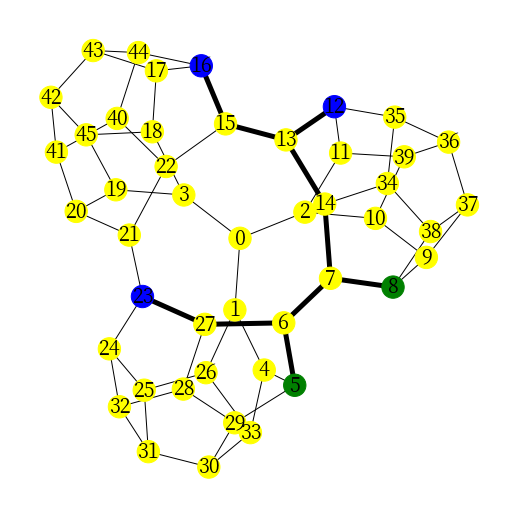

In [14]:
result = find_path_astar(inputs, outputs, common_neighbor)
visualize_graph_in_all(Graph=G, figsize=(7,7), node_size=500, weights=get_edge_weight(G, result),color_map=get_node_color_result(inputs, outputs, G))

## Steiner Tree

In [15]:
from itertools import count
from heapq import heappush, heappop

def _dijkstra_multisource(
    G, sources, weight, pred=None, paths=None, cutoff=None, target=None
):
    G_succ = G._succ if G.is_directed() else G._adj

    push = heappush
    pop = heappop
    dist = {}  # dictionary of final distances
    seen = {}
    # fringe is heapq with 3-tuples (distance,c,node)
    # use the count c to avoid comparing nodes (may not be able to)
    c = count()
    fringe = []
    for source in sources:
        if source not in G:
            raise nx.NodeNotFound(f"Source {source} not in G")
        seen[source] = 0
        push(fringe, (0, next(c), source))
    while fringe:
        (d, _, v) = pop(fringe)
        if v in dist:
            continue  # already searched this node.
        dist[v] = d
        if v == target:
            break
        for u, e in G_succ[v].items():
            cost = weight(v, u, e)
            if cost is None:
                continue
            vu_dist = dist[v] + cost
            if cutoff is not None:
                if vu_dist > cutoff:
                    continue
            if u in dist:
                u_dist = dist[u]
                if vu_dist < u_dist:
                    raise ValueError("Contradictory paths found:", "negative weights?")
                elif pred is not None and vu_dist == u_dist:
                    pred[u].append(v)
            elif u not in seen or vu_dist < seen[u]:
                seen[u] = vu_dist
                push(fringe, (vu_dist, next(c), u))
                if paths is not None:
                    paths[u] = paths[v] + [u]
                if pred is not None:
                    pred[u] = [v]
            elif vu_dist == seen[u]:
                if pred is not None:
                    pred[u].append(v)
    return dist

In [16]:
def multi_source_dijkstra(G, sources, target=None, cutoff=None, weight="weight"):
    if target in sources:
        return (0, [target])
    weight = lambda u, v, data: data.get(weight, 1)
    paths = {source: [source] for source in sources}  # dictionary of paths
    dist = _dijkstra_multisource(G, sources, weight, paths=paths)
    if target is None:
        return (dist, paths)
    try:
        return (dist[target], paths[target])
    except KeyError as e:
        raise nx.NetworkXNoPath(f"No path to {target}.") from e

In [17]:
def my_all_pairs_dijkstra(G):
    i = 0
    for n in G:
        i += 1
        print('\r%s' % i, end = '\r')
        dist, path = multi_source_dijkstra(G, {n})
        yield (n, (dist, path))

In [18]:
def metric_closure(G, weight="weight"):
    M = nx.Graph()

    Gnodes = set(G)

    all_paths_iter = my_all_pairs_dijkstra(G)
    for u, (distance, path) in all_paths_iter:
        Gnodes.remove(u)
        for v in Gnodes:
            M.add_edge(u, v, distance=distance[v], path=path[v])

    return M

In [19]:
from itertools import chain
from networkx.utils import pairwise


def my_steiner_tree(G, terminal_nodes, weight="weight"):
    global mcg
    
    # H is the subgraph induced by terminal_nodes in the metric closure M of G. 
    M = metric_closure(G, weight=weight) # O(|GV|^2)
    H = M.subgraph(terminal_nodes) # O(|GV|^2) * O(|MOrig| + |MDest|)
    
    # Use the 'distance' attribute of each edge provided by M.
    mst_edges = nx.minimum_spanning_edges(H, weight="distance", data=True) # O (|GE| log GV)
    
    
    # Create an iterator over each edge in each shortest path; repeats are okay
    edges = chain.from_iterable(pairwise(d["path"]) for u, v, d in mst_edges)
    

    T = G.edge_subgraph(edges)
    
    return T

In [20]:
def find_path_steiner(G: nx.Graph, MOrig: List, MDest: List) -> nx.Graph:
    
    return my_steiner_tree(G, MOrig + MDest)

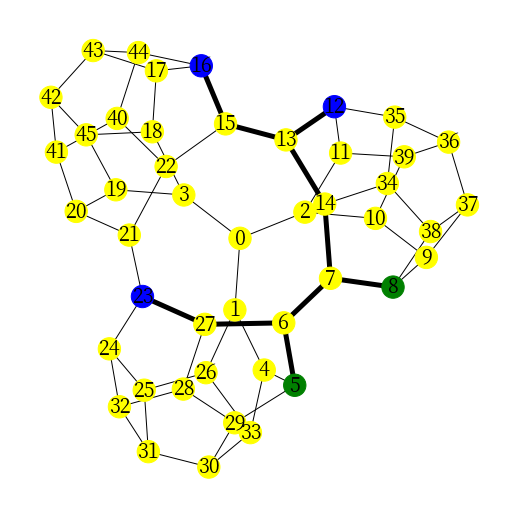

In [21]:
result = find_path_steiner(G, inputs, outputs)
visualize_graph_in_all(Graph=G, figsize=(7,7), node_size=500, weights=get_edge_weight(G, result),color_map=get_node_color_result(inputs, outputs, G))

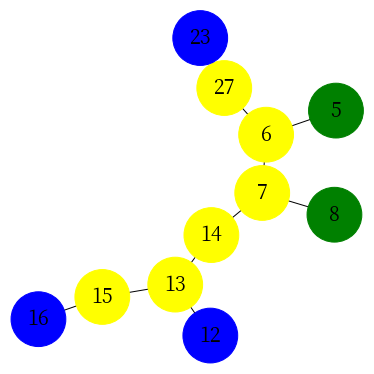

In [22]:
result = find_path_bf(inputs, outputs)
visualize_graph(Graph=result, figsize=(5,5), color_map=get_node_color_result(inputs, outputs, result))